In [16]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import time


In [17]:
print(torch.cuda.is_available()) 
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

True


In [18]:
width = 512 if torch.cuda.is_available() else 512
height = 512  if torch.cuda.is_available() else 512

convert = transforms.ToPILImage()

transformer = transforms.Compose([
    transforms.Resize((height,width),interpolation=Image.NEAREST), 
    transforms.ToTensor()]) 

def resize( image, size):
    resizer = transforms.Compose([ transforms.Resize((size[1], size[0]),interpolation=Image.NEAREST) ]) 
    return resizer(image)

def load_image(image_name):
    orig_image = Image.open(image_name)
    return orig_image

def transform( orig_image ):
    image = transformer(orig_image).unsqueeze(0).to(device, torch.float)
    if (image.size())[1] != 3:
        image = torch.cat([image,image,image], dim=1)
        
    return image

def display_image( image ):
    display = image.cpu().clone()
    display = display.squeeze(0)
    display = convert(display)
    print(display.size)
    plt.imshow(display)

In [19]:
class content_loss(nn.Module):
    def __init__(self, content_layer):
        super(content_loss, self).__init__()
        self.content_layer = content_layer.detach()

    def forward(self, input_image_layer):
        self.loss = F.mse_loss(input_image_layer, self.content_layer)
        return input_image_layer

In [20]:
def gram_matrix(image):
    (b, c, h, w) = image.size()
    features = image.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    G = features.bmm(features_t) / (c * h * w)
    return G

In [21]:
class style_loss(nn.Module):
    def __init__(self, style_image_layer):
        super(style_loss, self).__init__()
        self.gram_style = gram_matrix(style_image_layer).detach()

    def forward(self, input_image_layer):
        G = gram_matrix(input_image_layer)
        self.loss = F.mse_loss(G, self.gram_style)
        return input_image_layer

In [22]:
def initialize(cnn, style_image, content_image, content_layers, style_layers):
    normalization_module = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)).to(device) #nn.InstanceNorm2d(3).to(device) 

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization_module)
    
    content_layer_num = len(content_layers)
    style_layer_num = len(style_layers)
    convnet_num = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            convnet_num += 1
            name = 'conv_{}'.format(convnet_num)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(convnet_num)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(convnet_num)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(convnet_num)
        else:
            raise RuntimeError('')

        model.add_module(name, layer)

        if name in content_layers:
            content_layer = model(content_image).detach()
            Jc_l = content_loss(content_layer)
            model.add_module("content_loss_{}".format(convnet_num), Jc_l)
            content_losses.append(Jc_l)
            content_layer_num -= 1
            
        if name in style_layers:
            style_layer = model(style_image).detach()
            Js_l = style_loss(style_layer)
            model.add_module("style_loss_{}".format(convnet_num), Js_l)
            style_losses.append(Js_l)
            style_layer_num -= 1
            
        if style_layer_num == 0 and content_layer_num == 0:
            break

    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], content_loss ) or isinstance(model[i], style_loss ):
            break

    model = model[:(i + 1)]
    
    print(model)

    return model, content_losses, style_losses


In [49]:
def Optimizer(input_image):
    optimizer = optim.Adam([input_image.requires_grad_()], lr = 0.001) #Optimizer for CNN (Try with LBFGS)
    return optimizer

In [50]:
def transfer_style(cnn, content_image, style_image, input_image, content_layers, style_layers,
                       epoch=600, lamda_style=10000000, lamda_content=1):
    print('Building the style transfer model..')
    model, content_losses, style_losses = initialize(cnn, style_image, content_image, content_layers, style_layers)
    optimizer = Optimizer(input_image)
    
    
    print('Optimizing..')
    for iteration in range(1,epoch+1):
        input_image.data.clamp_(0, 1)
        #torch.cuda.empty_cache()
        optimizer.zero_grad()
        model(input_image)

        J_s = 0
        J_c = 0

        for c_loss in content_losses:
            J_c += c_loss.loss
        for s_loss in style_losses:
            J_s += s_loss.loss

        J_s_weighted = lamda_style*J_s 
        J_c_weighted = lamda_content*J_c 
        J = J_s_weighted + J_c_weighted
        J.backward()

        if iteration % 10 == 0:
            print("Iteration {}:".format(iteration))
            print('Weighted Style Loss : {:4f} Weighted Content Loss: {:4f}'.format(
            J_s_weighted.item(), J_c_weighted.item()))
            print()
            
        optimizer.step()

    input_image.data.clamp_(0, 1)

    return input_image

In [51]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

content_layers = ['relu_3', 'relu_4']
style_layers = ['relu_1', 'relu_2', 'relu_3', 'relu_4', 'relu_5']

torch.Size([1, 3, 512, 512])
(512, 512)


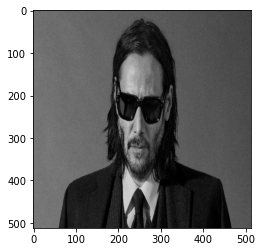

In [52]:
#Content Image 
content_image = load_image("./images/content_images/keanu.jpeg")
orig_size = content_image.size
content_image = transform(content_image)
print(content_image.size())
display_image(content_image)

(512, 512)


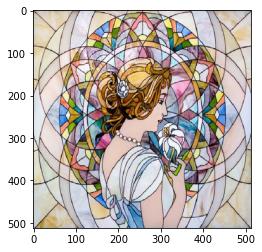

In [53]:
#Style Image
style_image = load_image("./images/style_images/mosaic.jpeg")
style_image = transform(style_image)
display_image(style_image)

(512, 512)


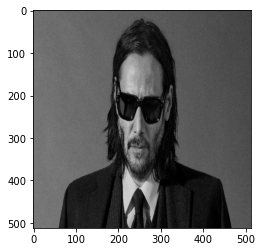

In [54]:
#Input Image
input_image =  content_image.clone().to(device)# torch.rand(content_image.data.size(), device=device) 
display_image(input_image)

In [55]:
tic = time.time()
output_image = transfer_style(cnn, content_image, style_image, input_image, content_layers, style_layers)
toc = time.time()
elapsed=toc - tic
print("Elapsed time {} second".format(elapsed) )

Building the style transfer model..
Sequential(
  (0): Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (style_loss_1): style_loss()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (style_loss_2): style_loss()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (content_loss_3): content_loss()
  (style_loss_3): style_loss()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (content_loss_4): content_loss()
  (style_loss_4): style_loss()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU()
  (style_loss_5): style

(512, 512)


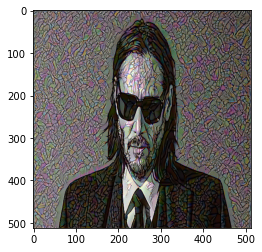

In [56]:
#output_image = resize(output_image, orig_size)
display_image(output_image)
